### Normalizations in deep learning

#### Batch norm (Ioffe & Szegedy, 2015)
- **Internal covariate shift**, defined as the change in the distribution of network activations due to the change in network parameters during training.
- The goal of batch norm is to reduce internal covariate shift by normalizing each mini-batch of data using the mini-batch mean and variance. For a mini-batch of inputs $\{x_1, \ldots, x_m\}$, we compute
$$\mu = \frac{1}{m} \sum_{i=1}^{m} x_i$$
$$\sigma^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu)^2$$

and then replace each $x_i$ with its normalized version
$$\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}$$

#### Layer norm (Ba, Kiros, & Hinton, 2016)

- Layer norm attempted to address some shortcomings of batch norm:
    1. It’s unclear how to apply batch norm in RNNs
    2. Batch norm needs large mini-batches to estimate statistics accurately
- Instead of normalizing examples across mini-batches, layer normalization normalizes features *within each example*. For input $x_i$ of dimension $D$, we compute
$$\mu = \frac{1}{D} \sum_{d=1}^{D} x_i^d$$
$$\sigma^2 = \frac{1}{D} \sum_{d=1}^{D} (x_i^d - \mu)^2$$

and then replace each component $x^d_i$ with its normalized version
$$\hat{x}_i^d = \frac{x_i^d - \mu}{\sqrt{\sigma^2 + \epsilon}}$$

#### Instance norm (Ulyanov, Vedaldi, & Lempitsky, 2016)
- Instance norm hit arXiv just 6 days after layer norm, and is pretty similar. Instead of normalizing all of the features of an example at once, instance norm normalizes features within each channel.

#### Group norm (Wu & He, 2018)
- Group norm is somewhere between layer and instance norm — instead of normalizing features within each channel, it normalizes features within pre-defined groups of channels.

<img src=attachment:image.png width=550>
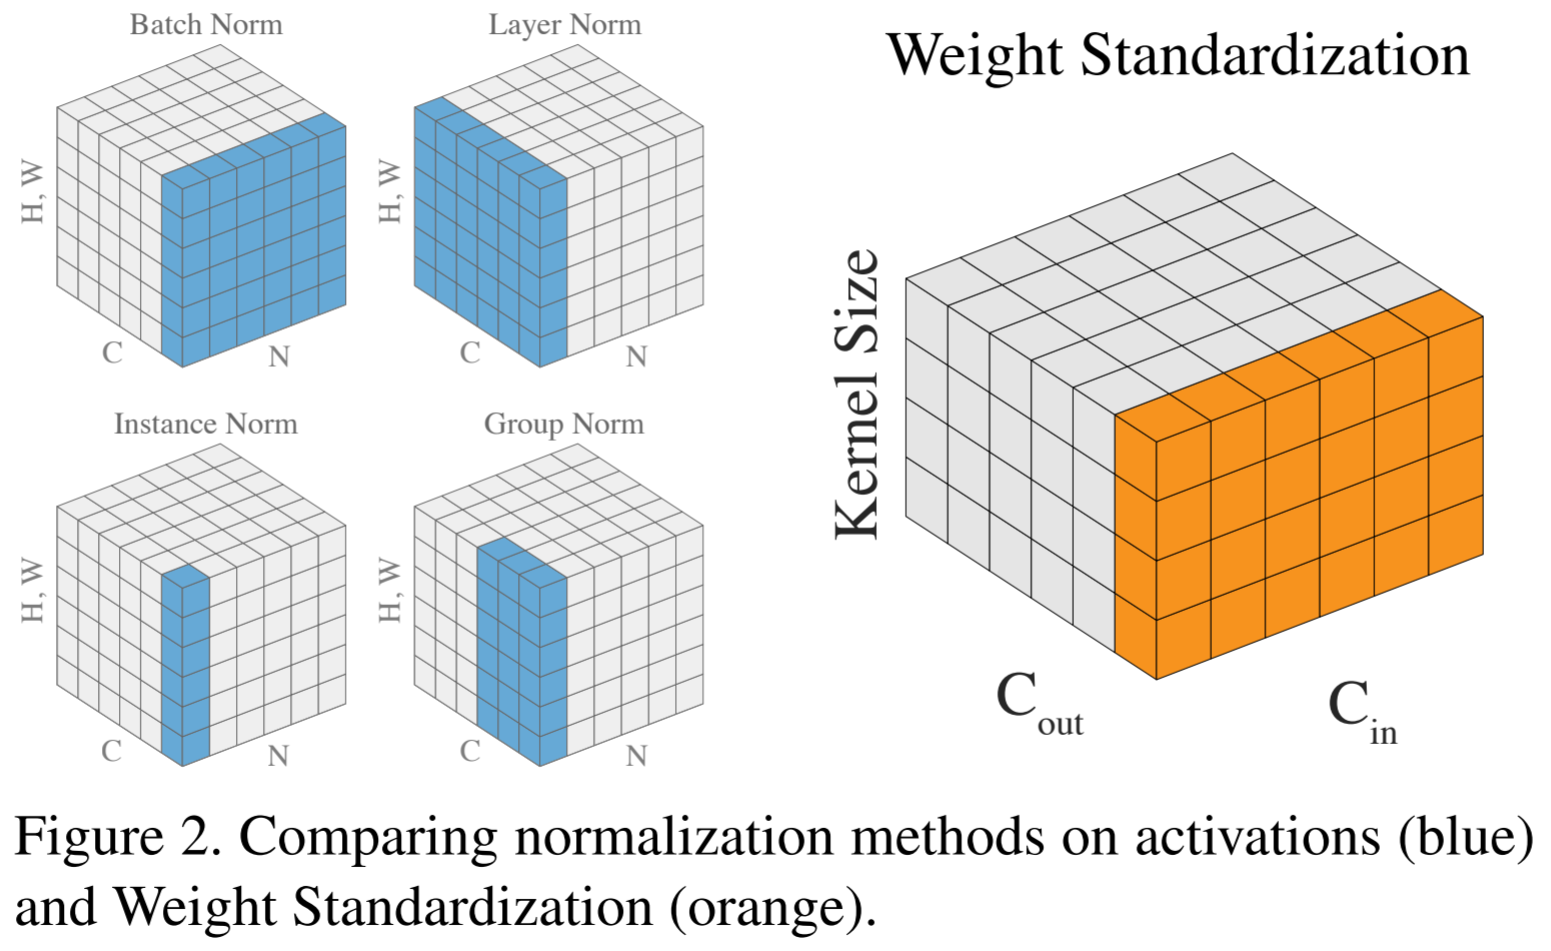

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import random
import numpy as np

from torchvision.utils import make_grid
import matplotlib.pyplot as plt

device = torch.device("cuda:0")

#### STL-10 Datasets

In [2]:
stl_train = datasets.STL10(root='STL10_data/',
                          split='train',
                          transform=transforms.ToTensor(),
                          download=True)

Files already downloaded and verified


In [3]:
train_loader = torch.utils.data.DataLoader(dataset=stl_train,
                                          batch_size=16,
                                          shuffle=True,
                                          drop_last=True)

In [4]:
img, label= next(iter(train_loader))

In [5]:
def show(img):
    npimg = img.numpy()
    xx = np.transpose(npimg, (1,2,0)) 
    plt.figure(figsize=(8,8))
    plt.imshow(xx)

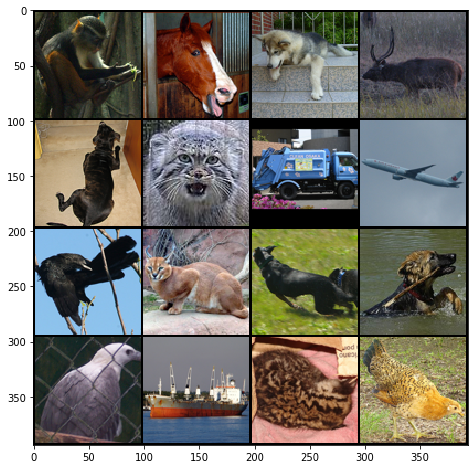

In [6]:
grid_img = make_grid(img, nrow=4)
show(grid_img)

#### Batch Norm

In [7]:
def print_mean_std(name, tensor):
    print('-----------------------------------')
    print('*', name)

    print('per channel for a whole batch - the goal of batch norm')
    print('mean:', tensor.detach().mean(dim=(0,2,3)).mean())
    print('std:', tensor.detach().std(dim=(0,2,3)).mean())    
    
    print('per each example in minibatch - the goal of layer norm')
    print('mean:', tensor.detach().mean(dim=(1,2,3)).mean())
    print('std:', tensor.detach().std(dim=(1,2,3)).mean())       
    
    print('statistics over only spatial dims, (H,W) - the goal of instance norm')
    print('mean:', tensor.detach().mean(dim=(1,2)).mean())
    print('std:', tensor.detach().std(dim=(1,2)).mean())       

In [8]:
class BnNet(nn.Module):
    def __init__(self):
        super(BnNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, 
                               out_channels=32,
                               kernel_size=5,
                               stride=2,                               
                              )
        self.conv1_bn = nn.BatchNorm2d(num_features=32, eps=0, affine=False)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=2)
        self.conv2_bn = nn.BatchNorm2d(num_features=64, eps=0, affine=False)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=2)
        self.conv3_bn = nn.BatchNorm2d(num_features=128, eps=0, affine=False)
        
        self.fc1 = nn.Linear(in_features=128*9*9, out_features=100)
        self.fc1_bn = nn.BatchNorm1d(100, eps=0, affine=False)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        
        print_mean_std('input', x)
        
        x = self.conv1(x)
        print_mean_std('conv1: before bn', x)
        x = self.conv1_bn(x)
        print_mean_std('conv1: after bn', x)
        
        x = self.conv2(x)
        print_mean_std('conv2: before bn', x)
        x = self.conv2_bn(x)
        print_mean_std('conv2: after bn', x)
        
        x = self.conv3(x)
        print_mean_std('conv3: before bn', x)        
        x = self.conv3_bn(x)
        print_mean_std('conv3: after bn', x)        
        
        x = x.view(-1, 128*9*9)
        
        x = self.fc1(x)
        x = self.fc1_bn(x)
        x = self.fc2(x)

        return x

In [9]:
train_loader = torch.utils.data.DataLoader(dataset=stl_train,
                                          batch_size=128,
                                          shuffle=True,
                                          drop_last=True)
img, label= next(iter(train_loader))

In [10]:
net = BnNet()

In [11]:
y = net(img)

-----------------------------------
* input
per channel for a whole batch - the goal of batch norm
mean: tensor(0.4275)
std: tensor(0.2683)
per each example in minibatch - the goal of layer norm
mean: tensor(0.4275)
std: tensor(0.2353)
statistics over only spatial dims, (H,W) - the goal of instance norm
mean: tensor(0.4275)
std: tensor(0.2174)
-----------------------------------
* conv1: before bn
per channel for a whole batch - the goal of batch norm
mean: tensor(-0.0519)
std: tensor(0.1498)
per each example in minibatch - the goal of layer norm
mean: tensor(-0.0519)
std: tensor(0.2990)
statistics over only spatial dims, (H,W) - the goal of instance norm
mean: tensor(-0.0519)
std: tensor(0.2957)
-----------------------------------
* conv1: after bn
per channel for a whole batch - the goal of batch norm
mean: tensor(-8.7481e-09)
std: tensor(1.0000)
per each example in minibatch - the goal of layer norm
mean: tensor(-3.2596e-09)
std: tensor(0.9733)
statistics over only spatial dims, (H,

#### Layer Norm

In [12]:
class LnNet(nn.Module):
    def __init__(self):
        super(LnNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, 
                               out_channels=32,
                               kernel_size=5,
                               stride=2,                               
                              )
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=2)      
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=2)
        
        self.fc1 = nn.Linear(in_features=128*9*9, out_features=100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        
        print_mean_std('input', x)
        
        x = self.conv1(x)
        print_mean_std('conv1: before ln', x)
        x = nn.LayerNorm(x.size()[1:], elementwise_affine=False)(x)
        print_mean_std('conv1: after ln', x)
        
        x = self.conv2(x)
        print_mean_std('conv2: before ln', x)
        x = nn.LayerNorm(x.size()[1:], elementwise_affine=False)(x)
        print_mean_std('conv2: after ln', x)
        
        x = self.conv3(x)
        print_mean_std('conv3: before ln', x)        
        x = nn.LayerNorm(x.size()[1:], elementwise_affine=False)(x)
        print_mean_std('conv3: after ln', x)        
        
        x = x.view(-1, 128*9*9)
        
        x = self.fc1(x)
        x = nn.LayerNorm(x.size()[1:], elementwise_affine=False)(x)
        x = self.fc2(x)

        return x

In [13]:
net = LnNet()
y = net(img)

-----------------------------------
* input
per channel for a whole batch - the goal of batch norm
mean: tensor(0.4275)
std: tensor(0.2683)
per each example in minibatch - the goal of layer norm
mean: tensor(0.4275)
std: tensor(0.2353)
statistics over only spatial dims, (H,W) - the goal of instance norm
mean: tensor(0.4275)
std: tensor(0.2174)
-----------------------------------
* conv1: before ln
per channel for a whole batch - the goal of batch norm
mean: tensor(-0.0812)
std: tensor(0.1472)
per each example in minibatch - the goal of layer norm
mean: tensor(-0.0812)
std: tensor(0.3234)
statistics over only spatial dims, (H,W) - the goal of instance norm
mean: tensor(-0.0812)
std: tensor(0.3191)
-----------------------------------
* conv1: after ln
per channel for a whole batch - the goal of batch norm
mean: tensor(-1.4901e-08)
std: tensor(0.4326)
per each example in minibatch - the goal of layer norm
mean: tensor(1.6703e-09)
std: tensor(1.0000)
statistics over only spatial dims, (H,W

#### Instance Norm

- torch.nn.modules.instancenorm()
- Applies Instance Normalization over a 3D input (a mini-batch of 1D
    inputs with optional additional channel dimension) as described in the paper
    `Instance Normalization: The Missing Ingredient for Fast Stylization`
    
$$ y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$$

In [14]:
class InNet(nn.Module):
    def __init__(self):
        super(InNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, 
                               out_channels=32,
                               kernel_size=5,
                               stride=2,                               
                              )
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=2)      
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=2)
        
        self.fc1 = nn.Linear(in_features=128*9*9, out_features=100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        
        print_mean_std('input', x)
        
        x = self.conv1(x)
        print_mean_std('conv1: before ln', x)
        x = nn.InstanceNorm2d(num_features=32, affine=False)(x)
        print_mean_std('conv1: after ln', x)
        
        x = self.conv2(x)
        print_mean_std('conv2: before ln', x)
        x = nn.InstanceNorm2d(num_features=64, affine=False)(x)
        print_mean_std('conv2: after ln', x)
        
        x = self.conv3(x)
        print_mean_std('conv3: before ln', x)        
        x = nn.InstanceNorm2d(num_features=128, affine=False)(x)
        print_mean_std('conv3: after ln', x)        
        
        x = x.view(-1, 128*9*9)
        
        x = self.fc1(x)
        x = self.fc2(x)

        return x

In [15]:
net = InNet()
y = net(img)

-----------------------------------
* input
per channel for a whole batch - the goal of batch norm
mean: tensor(0.4275)
std: tensor(0.2683)
per each example in minibatch - the goal of layer norm
mean: tensor(0.4275)
std: tensor(0.2353)
statistics over only spatial dims, (H,W) - the goal of instance norm
mean: tensor(0.4275)
std: tensor(0.2174)
-----------------------------------
* conv1: before ln
per channel for a whole batch - the goal of batch norm
mean: tensor(-0.0831)
std: tensor(0.1463)
per each example in minibatch - the goal of layer norm
mean: tensor(-0.0831)
std: tensor(0.3134)
statistics over only spatial dims, (H,W) - the goal of instance norm
mean: tensor(-0.0831)
std: tensor(0.3096)
-----------------------------------
* conv1: after ln
per channel for a whole batch - the goal of batch norm
mean: tensor(-1.0799e-09)
std: tensor(0.9993)
per each example in minibatch - the goal of layer norm
mean: tensor(-9.6733e-10)
std: tensor(0.9993)
statistics over only spatial dims, (H,

- nn.GroupNorm()